# Grid Search Inspection

Interpreting the results of the grid search run over the different parameter combinations. The grid search was not comprehensive in scope as the number of combinations grows as $O(\theta_1^m \times \theta_2^n \times \dots \times \theta_k^o)$ where $\theta$ is the parameter being explored and its exponent is the number of options to explore over that parameter. As such, the grid_search was restricted to heuristic ranges.

In [62]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

Necessary to do this hard coding because of an oversight in the code before running the grid search. To fix this in future versions a \_\_str__() method has be added.

In [82]:
df = pd.read_pickle('./gridsearch_results.pkl')
df.sort_values('Accuracy', ascending=False)

func_match = {None: None, '0x7fdf9e06f040': 'torch.sum', '0x7fdfbac48f40': 'torch.mean'}

df['Aggregation'] = df['Aggregation'].apply(lambda x: x.split('.')[1].replace('\'>', ''))
df = df.fillna('None')
df['Subtoken Aggregation?'] = df['Subtoken Aggregation?'].apply(lambda x: (match := re.findall(r'0x.{12}', x), func_match[match[0]] if len(match) > 0 else 'None')[1])
df.sort_values('Accuracy', ascending=False)

,Aggregation,Layers,Subtoken Aggregation?,Seed,Accuracy,Threshold
647,SumNLayers,"(-4, None)",torch.mean,100,62.303847,1.0
431,MeanNLayers,"(-4, None)",torch.mean,100,62.303847,1.0
646,SumNLayers,"(-4, None)",torch.mean,100,62.303847,0.6
430,MeanNLayers,"(-4, None)",torch.mean,100,62.303847,0.6
645,SumNLayers,"(-4, None)",torch.mean,100,62.234104,0.5
...,...,...,...,...,...,...
202,CatNLayers,"(-4, None)",torch.mean,42,27.885621,0.2
562,SumNLayers,"(-4, None)",torch.sum,42,27.513658,0.2
346,MeanNLayers,"(-4, None)",torch.sum,42,27.513658,0.2
634,SumNLayers,"(-4, None)",torch.mean,42,27.420667,0.2


In [3]:
aggregation = df.groupby(['Aggregation', 'Layers', 'Subtoken Aggregation?', 'Threshold'], dropna=False).agg({'Accuracy': ['min', 'max', 'mean', 'std', ('midrange', lambda x: (min(x) + max(x)) / 2), ('difference', lambda x: (min(x) + max(x)) / 2 - min(x))]})

aggregation.sort_values(('Accuracy',   'midrange'), ascending=False)

Accuracy             \
                                                              min        max   
Aggregation Layers     Subtoken Aggregation? Threshold                         
CatNLayers  (-4, None) torch.sum             0.6        48.053005  55.992096   
                                             1.0        48.064629  55.980472   
                                             0.5        48.041381  55.957224   
                                             0.4        47.622922  55.724747   
MeanNLayers (-4, None) torch.mean            0.6        39.811694  62.303847   
...                                                           ...        ...   
            (-2, None) NaN                   0.3        29.791933  35.673602   
SumNLayers  (-2, None) NaN                   0.3        29.780309  35.673602   
CatNLayers  (-3, None) NaN                   0.3        31.489015  33.813786   
SumNLayers  (-2, None) torch.sum             0.2        31.500639  33.406951   
MeanNLayers (-2, None) torch.sum             0.2        31.489015  33.406951   

                                                                              \
                                                             mean        std   
Aggregation Layers     Subtoken Aggregation? Threshold                         
CatNLayers  (-4, None) torch.sum             0.6        51.276686   4.174474   
                                             1.0        51.280561   4.161344   
                                             0.5        51.284436   4.147077   
                                             0.4        50.997714   4.216789   
MeanNLayers (-4, None) torch.mean            0.6        48.184742  12.297851   
...                                                           ...        ...   
            (-2, None) NaN                   0.3        33.127979   3.019451   
SumNLayers  (-2, None) NaN                   0.3        33.124104   3.025873   
CatNLayers  (-3, None) NaN                   0.3        32.275563   1.332254   
SumNLayers  (-2, None) torch.sum             0.2        32.353055   0.968995   
MeanNLayers (-2, None) torch.sum             0.2        32.349181   0.974118   

                                                                              
                                                         midrange difference  
Aggregation Layers     Subtoken Aggregation? Threshold                        
CatNLayers  (-4, None) torch.sum             0.6        52.022550   3.969546  
                                             1.0        52.022550   3.957922  
                                             0.5        51.999303   3.957922  
                                             0.4        51.673835   4.050912  
MeanNLayers (-4, None) torch.mean            0.6        51.057771  11.246077  
...                                                           ...        ...  
            (-2, None) NaN                   0.3        32.732768   2.940835  
SumNLayers  (-2, None) NaN                   0.3        32.726956   2.946647  
CatNLayers  (-3, None) NaN                   0.3        32.651401   1.162385  
SumNLayers  (-2, None) torch.sum             0.2        32.453795   0.953156  
MeanNLayers (-2, None) torch.sum             0.2        32.447983   0.958968  

[216 rows x 6 columns]

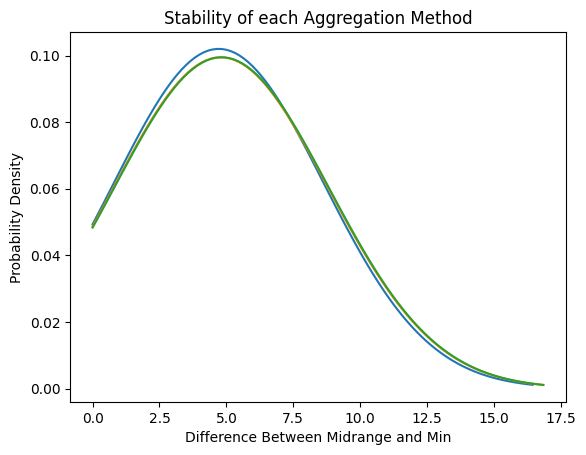

In [63]:
catnlayers_only = df[df['Aggregation'] == 'CatNLayers']
sumnlayers_only = df[df['Aggregation'] == 'SumNLayers']
meannlayers_only = df[df['Aggregation'] == 'MeanNLayers']

def get_diff(df):
    df = df.groupby(['Layers', 'Subtoken Aggregation?', 'Threshold'], dropna=False).agg({'Accuracy': ['min', 'max', 'mean', 'std', ('midrange', lambda x: (min(x) + max(x)) / 2), ('difference', lambda x: (min(x) + max(x)) / 2 - min(x))]})
    return df.agg({('Accuracy', 'difference'): ['mean', 'std']})

diffs = [get_diff(df) for df in [catnlayers_only, sumnlayers_only, meannlayers_only]]

for d in diffs:
    mu, sigma = d.values
    x = np.linspace(0, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.xlabel('Difference Between Midrange and Min')
plt.ylabel('Probability Density')
plt.title('Stability of each Aggregation Method')
plt.show()


In [115]:
no_subtok_agg = df[(df['Subtoken Aggregation?'] == 'None') & (df['Threshold'] == 'None')]
grouped = no_subtok_agg.groupby(['Layers', 'Seed'], dropna=False).agg({'Accuracy': [('Count Same', lambda x: sum([x.iloc[i] == x.iloc[j] for i in range(len(x)) for j in range(len(x)) if i != j]))]})

print(grouped)

                  Accuracy
                Count Same
Layers     Seed           
(-4, None) 0             2
           42            2
           100           2
(-3, None) 0             0
           42            0
           100           2
(-2, None) 0             2
           42            0
           100           0


In [126]:
layer_12 = np.array([-1, 2, 3, 4, 0.5])
layer_13 = np.array([-0.5, -4, 4, 3.5, 0.25])

sum_layers = np.sum((layer_12, layer_13), axis=0)
avg_layers = np.mean((layer_12, layer_13), axis=0)

print(sum_layers)
print(avg_layers)
print(avg_layers * 2) # Only the magnitude of the vector is different

[-1.5  -2.    7.    7.5   0.75]
[-0.75  -1.     3.5    3.75   0.375]
[-1.5  -2.    7.    7.5   0.75]
